In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from umap import UMAP
from tqdm import tqdm

In [2]:
df = pd.read_csv('creditcard.csv')

In [3]:
len(df)

284807

<AxesSubplot:>

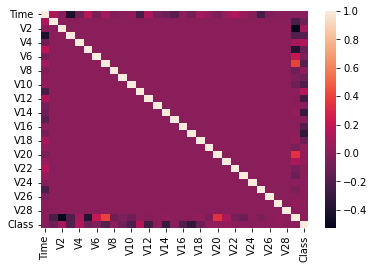

In [4]:
sns.heatmap(df.corr())

In [ ]:
%%time
dim_reduced_data = TSNE(random_state=42).fit_transform(df)
sns.scatterplot(dim_reduced_data[:, 0], dim_reduced_data[:, 1], c=labels)